In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import shutil
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping

In [2]:
# Transfering the variables from the preprocessing notebook
%store -r train_dir
%store -r val_dir
%store -r test_dir
%store -r val_datagen
%store -r test_datagen

In [3]:
# A basic rescaling for the preparation of the images
train_datagen = ImageDataGenerator(
    rescale = 1./255.)

Setting input size, batch size and class mode for ever generator

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 5025 images belonging to 5 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    batch_size = 2,
    target_size = (224, 224),
    class_mode = None, 
    shuffle = False) #No shuffling was applied in the test set

Found 2465 images belonging to 5 classes.


In [7]:
# Starting a sequential model
model = Sequential() 

2021-09-03 12:32:39.382996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Adding full connected layers with 1 flatten,2 dense (1 with relu and 1 with softmax) and 1 dropout

In [8]:
model.add(Flatten(input_shape = (224,224,3)))

In [9]:
model.add(Dense(1024, activation='relu'))

In [10]:
model.add(Dropout(0.25))

In [11]:
model.add(Dense(5, activation='softmax'))

In [12]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              154141696 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 154,146,821
Trainable params: 154,146,821
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks = [  
    # Stop training when val_loss has stopped improving
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    # Reduce learning rate when val_loss has stopped improving
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [15]:
inc_history = model.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

2021-09-03 12:32:41.302853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
20/20 [==============================] - 58s 3s/step - loss: 28.9790 - accuracy: 0.2175 - val_loss: 9.4258 - val_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - 54s 3s/step - loss: 7.6416 - accuracy: 0.2725 - val_loss: 2.6546 - val_accuracy: 0.3897
Epoch 3/100
20/20 [==============================] - 54s 3s/step - loss: 3.7089 - accuracy: 0.3775 - val_loss: 1.1359 - val_accuracy: 0.5178
Epoch 4/100
20/20 [==============================] - 55s 3s/step - loss: 1.6600 - accuracy: 0.4100 - val_loss: 1.0008 - val_accuracy: 0.4808
Epoch 5/100
20/20 [==============================] - 54s 3s/step - loss: 1.1300 - accuracy: 0.4700 - val_loss: 1.2032 - val_accuracy: 0.5081
Epoch 6/100
20/20 [==============================] - 53s 3s/step - loss: 1.1969 - accuracy: 0.4100 - val_loss: 1.1048 - val_accuracy: 0.4243
Epoch 7/100
20/20 [==============================] - 54s 3s/step - loss: 1.2042 - accuracy: 0.4175 - val_loss: 1.0710 - val_accuracy: 0.5560
Restoring mo

In [16]:
#Saving the model's weights and architecture
model.save('MLP-1.h5')

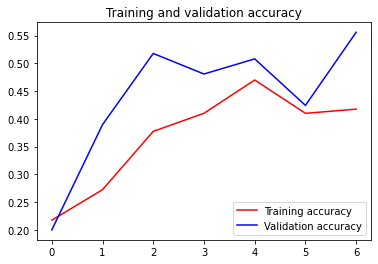

<Figure size 432x288 with 0 Axes>

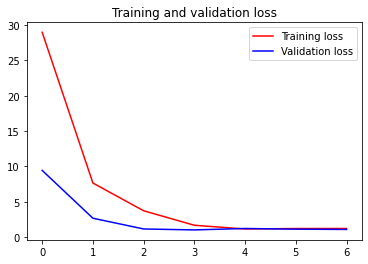

<Figure size 432x288 with 0 Axes>

In [17]:
#Plotting the metrics
import matplotlib.pyplot as plt

acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']
loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [18]:
pred_probs = model.predict(test_generator,verbose = 2)

1233/1233 - 48s


In [19]:
predicted_indices = np.argmax(pred_probs, axis=1)

In [20]:
# The predicted classes of the test set as an integer
predicted_indices

array([1, 1, 0, ..., 4, 4, 4])

In [21]:
# The default classes of the test directory as an integer
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices)

In [23]:
cm

array([[165, 324,   0,   3,   1],
       [309, 160,   0,  24,   0],
       [  3,  68,  35,   0, 387],
       [ 79,  37,   3, 373,   1],
       [  0,  26,   0,   0, 467]])

In [24]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [25]:
pd.DataFrame(cm,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,165,324,0,3,1
colon_n,309,160,0,24,0
lung_aca,3,68,35,0,387
lung_n,79,37,3,373,1
lung_scc,0,26,0,0,467


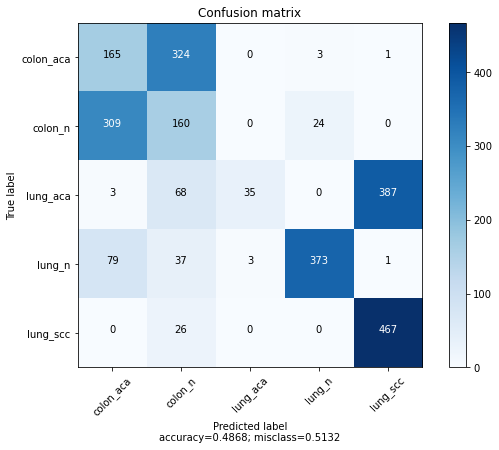

In [26]:
# Plotting a confusion matrix with extra features and a more analytical display
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm,target_names)


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.30      0.33      0.31       493
     colon_n       0.26      0.32      0.29       493
    lung_aca       0.92      0.07      0.13       493
      lung_n       0.93      0.76      0.84       493
    lung_scc       0.55      0.95      0.69       493

    accuracy                           0.49      2465
   macro avg       0.59      0.49      0.45      2465
weighted avg       0.59      0.49      0.45      2465



The comments for the commands will not be repeated in the second model since the parameters and the structure is the same

In [28]:
#Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [30]:
model2 = Sequential()

In [31]:
model2.add(Flatten(input_shape = (224,224,3)))

In [32]:
model2.add(Dense(1024, activation='relu'))

In [33]:
model2.add(Dropout(0.25))

In [34]:
model2.add(Dense(5, activation='softmax'))

In [35]:
model2.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [36]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              154141696 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 154,146,821
Trainable params: 154,146,821
Non-trainable params: 0
_________________________________________________________________


In [37]:
callbacks = [  
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [38]:
inc_history2 = model2.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

Epoch 1/100
20/20 [==============================] - 62s 3s/step - loss: 28.2300 - accuracy: 0.2250 - val_loss: 7.0064 - val_accuracy: 0.2006
Epoch 2/100
20/20 [==============================] - 58s 3s/step - loss: 9.2807 - accuracy: 0.2600 - val_loss: 2.6574 - val_accuracy: 0.3518
Epoch 3/100
20/20 [==============================] - 65s 3s/step - loss: 3.3609 - accuracy: 0.3675 - val_loss: 1.3356 - val_accuracy: 0.4796
Epoch 4/100
20/20 [==============================] - 90s 5s/step - loss: 1.3489 - accuracy: 0.4625 - val_loss: 1.0238 - val_accuracy: 0.4587
Epoch 5/100
20/20 [==============================] - 58s 3s/step - loss: 1.1408 - accuracy: 0.4800 - val_loss: 1.0065 - val_accuracy: 0.4971
Epoch 6/100
20/20 [==============================] - 59s 3s/step - loss: 1.1496 - accuracy: 0.4275 - val_loss: 1.0622 - val_accuracy: 0.5590
Epoch 7/100
20/20 [==============================] - 57s 3s/step - loss: 1.1653 - accuracy: 0.4350 - val_loss: 1.0907 - val_accuracy: 0.4418
Epoch 8/100


In [39]:
model2.save('MLP-2.h5')

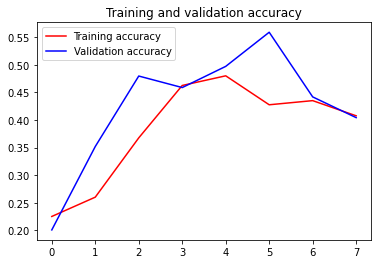

<Figure size 432x288 with 0 Axes>

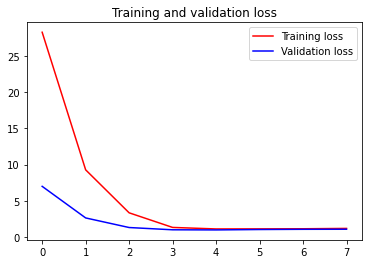

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

acc = inc_history2.history['accuracy']
val_acc = inc_history2.history['val_accuracy']
loss = inc_history2.history['loss']
val_loss = inc_history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [41]:
pred_probs2 = model2.predict(test_generator,verbose = 2)

1233/1233 - 54s


In [42]:
predicted_indices2 = np.argmax(pred_probs2, axis=1)

In [43]:
predicted_indices2

array([1, 0, 1, ..., 4, 4, 4])

In [44]:
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [45]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices2)

In [46]:
cm2

array([[ 82, 347,  43,  21,   0],
       [  4, 448,   0,  41,   0],
       [  9,   3, 121,   2, 358],
       [  1, 304,  37, 151,   0],
       [  0,   0,  48,   0, 445]])

In [47]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [48]:
pd.DataFrame(cm2,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,82,347,43,21,0
colon_n,4,448,0,41,0
lung_aca,9,3,121,2,358
lung_n,1,304,37,151,0
lung_scc,0,0,48,0,445


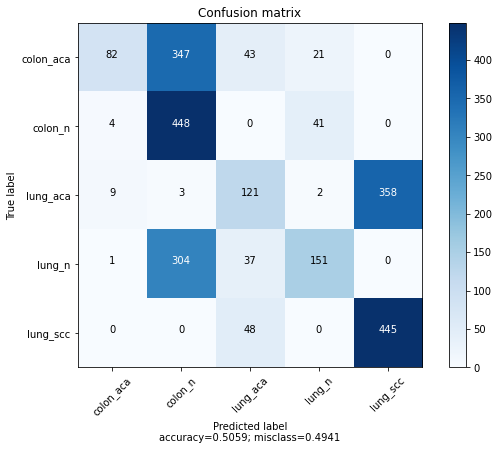

In [49]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm2,target_names)


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices2, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.85      0.17      0.28       493
     colon_n       0.41      0.91      0.56       493
    lung_aca       0.49      0.25      0.33       493
      lung_n       0.70      0.31      0.43       493
    lung_scc       0.55      0.90      0.69       493

    accuracy                           0.51      2465
   macro avg       0.60      0.51      0.46      2465
weighted avg       0.60      0.51      0.46      2465

